# 3b_FactorialSearch notebook, Vehciels clustering analysis

Project: clustering-analysis-domain-agnostic-features-2018

Authors: Jordan Perr-Sauer, Caleb Phillips

License: BSD 3-Clause

Copyright (c) 2021 Alliance for Sustainable Energy LLC

## Description

This notebook uses Spark to parallelize a hyperparameter search over the clustering analysis. It produces the violin plots in Figure 7 and the data in Table 4.

This notbook must be run with a spark context. The easiet way to do this is to boot up Spark using start_spark_jupyter_notebook.sh

In [1]:
%%time
%reset -f

%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import pyspark
from pyspark.sql import SparkSession, Row
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import math, random
import pickle
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt


sc = SparkSession.builder.getOrCreate().sparkContext

# Load feature dataframes from CSV
features_traditional = pd.read_csv("./data/FleetDNAETL_CoDA_epaprime_traditional_nolimit.csv").set_index("vdir").sort_index()
features_agnostic = pd.read_csv("./data/FleetDNAETL_CoDA_epaprime_agnostic_50klimit.csv").set_index("vdir").sort_index()
cols = [x for x in features_agnostic.columns if x[0]!='g']
features_agnostic = features_agnostic[cols]

# Load metadata from CSV
meta = pd.DataFrame.from_csv("./data/vehicle_specifications_fdna.csv")
m = meta.reset_index()
m["vdir"] = "v_" + m["id"].astype(str)
m = m.set_index("vdir").sort_index()


X_agnostic = features_agnostic
X_traditional = features_traditional

# Preprocessing

X_agnostic = X_agnostic.dropna(axis=1)
X_traditional = X_traditional.dropna(axis=1)

def normalize(df):
    return (df-df.min())/(df.max()-df.min())

X_agnostic = normalize(features_agnostic).dropna(axis=1)
X_traditional = normalize(features_traditional).dropna(axis=1)

X_agnostic = X_agnostic.reindex_axis(sorted(X_agnostic.columns), axis=1)

corr_matrix = X_agnostic.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_agnostic = X_agnostic.drop(to_drop, axis=1)

corr_matrix = X_traditional.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_traditional = X_traditional.drop(to_drop, axis=1)

X_traditional = normalize(X_traditional)
X_agnostic = normalize(X_agnostic)


def clusters(alg, data, index):
    C = alg.fit_predict(data)
    return pd.DataFrame(C).set_index(index)

def do_projection(p,f):
    proj = p.fit_transform(f)
    proj = pd.DataFrame(proj).set_index(f.index)
    proj = normalize(proj) # This helps guard against bias due to scale
    return proj


### Define VI

def variation_of_information_direct(X, Y):
    """
    Compute the variation of information between two cluster labelings
    Should be bounded by 0 <= vi <= ln(n)
    """
    dict_X = {}
    for x in set(X):
        dict_X[x] = []
    for i in range(len(X)):
        dict_X[X[i]].append(i)
    dict_Y = {}
    for y in set(Y):
        dict_Y[y] = []
    for i in range(len(Y)):
        dict_Y[Y[i]].append(i)

    n = float(len(X))

    VI = 0
    for i in dict_X.keys():
        for j in dict_Y.keys():
            Xi = set(dict_X[i])
            Yj = set(dict_Y[j])
            pi = len(Xi) / n
            qj = len(Yj) / n
            rij = len(Xi.intersection(Yj)) / n
            if rij != 0:
                VI = VI + rij * (math.log(rij / pi, 2) + math.log(rij / qj, 2))

    return -VI

def vi(left, right):
    comp = left.merge(right, how='inner', right_index=True, left_index=True)
    return variation_of_information_direct(np.array(comp["0_x"]), np.array(comp["0_y"]))


# Set up the parallel computation

#_bcast_ground_truth = sc.broadcast(ground_truth)
_bcast_features_agnostic = sc.broadcast(X_agnostic)
_bcast_features_traditional = sc.broadcast(X_traditional)
_bcast_metadata = sc.broadcast(m)


def unpack_projection(dict_projection):
    if dict_projection[u"type"] == u"PCA":
        return PCA(n_components=dict_projection[u"n_components"])
    elif dict_projection[u"type"] == u"TSNE":
        return TSNE(perplexity=dict_projection[u"perplexity"])
    else:
        return dict_projection

def unpack_clusteting(dict_clustering):
    if dict_clustering[u"type"] == u"KMeans":
        return KMeans(n_clusters=dict_clustering[u"n"])
    elif dict_clustering[u"type"] == u"DBSCAN":
        return DBSCAN(eps=dict_clustering[u"eps"])
    else:
        return dict_clustering

def unpack_features(dict_features):
    if dict_features == u"traditional":
        return _bcast_features_traditional.value
    elif dict_features == u"agnostic":
        return _bcast_features_agnostic.value
    else:
        raise Exception("Features value was {}".format(dict_features))
    
def unpack_labels(cd):
    return cd["features"], cd["projection"][u"type"], cd["clustering"][u"type"]

def unpack(cd):
    features = unpack_features(cd["features"])
    projection = unpack_projection(cd["projection"])
    clustering = unpack_clusteting(cd["clustering"])
    return features, projection, clustering

def constraints(c):
    if (c[0].value_counts() < 10).any():
        return "some cluster has less than 10"
    if len(set(c[0].to_dict().values())) < 3:
        return "not at least three clusters"
    else:
        return False

def do_computation(computation_descriptor):
    # Unpack argument for this computation from Pyspark cell
    cd = json.loads(computation_descriptor)
    features, projection, clustering = unpack(cd)
    features_label, projection_label, clustering_label = unpack_labels(cd)
    
    # Execute the computation
    p = do_projection(projection, features)
    c = clusters(clustering, p, features.index)
    
    # Enforce constraints
    if constraints(c):
        return None
    
    # Compute metrics
    _silhouette_score = silhouette_score(p, c)
    
    _vi = {}
    m = _bcast_metadata.value
    ground_truth_cols = ['class', 'vocation', 'vehicletype', 'providers']
    c.columns = map(str, c.columns)
    merged = c.merge(m[ground_truth_cols], how='inner', right_index=True, left_index=True)
    for col_name in ground_truth_cols:
        ourMerge = merged[["0", col_name]].dropna()
        vvi = variation_of_information_direct(np.array(ourMerge["0"]), np.array(ourMerge[col_name]))
        _vi["vi_{}".format(col_name)] = vvi
    
    
    ans = {"features":features_label,
            "projection":projection_label,
            "clustering":clustering_label,
            "silhouette_score":_silhouette_score}
    
    ans.update(_vi)
    
    return ans

# Create a collection of experiment configuration parameters
random.seed(2018)
feature_opts = ["traditional", "agnostic"]

clustering_opts_dbscan = [{"type":"DBSCAN", "eps":n} for n in np.linspace(0.01,.1,10)]
clustering_opts_kmeans = [{"type":"KMeans", "n":n} for n in range(2,5)]
clusetring_opts = itertools.chain(clustering_opts_dbscan, clustering_opts_kmeans)

projection_opts_PCA = [{"type":"PCA", "n_components":2}]
projection_opts_TSNE = [{"type":"TSNE", "perplexity":p} for p in np.linspace(5,50,10)]
projection_opts = itertools.chain(projection_opts_PCA, projection_opts_TSNE)

product_tuple = itertools.product(clusetring_opts, projection_opts, feature_opts)
configuration_dict = [{"clustering":_c0, "projection":_c1, "features":_c2} for _c0, _c1, _c2 in product_tuple]
configuration_json = map(json.dumps, configuration_dict)

# Run map over parallelized rdd
configuration_rdd = sc.parallelize(configuration_json, len(configuration_json))
spark_result = configuration_rdd.map(do_computation)

CPU times: user 2.3 s, sys: 2.04 s, total: 4.34 s
Wall time: 2.76 s


### The following cell will execute a potentially time consuming spark job

In [2]:
len(configuration_json)

286

In [3]:
answer = spark_result.collect()

In [7]:
df = pd.DataFrame([a for a in answer if a])

# Factor Analysis

In [12]:
# Table of factor sensitivities
metrics = ["silhouette_score", "vi_class", "vi_vehicletype", "vi_vocation"]

# Clustering
c = df.groupby("clustering").agg(['mean', 'std', 'min'])
f = df.groupby("features").agg(['mean', 'std', 'min'])
p = df.groupby("projection").agg(['mean', 'std', 'min'])



In [13]:
p["type"] = "projection"
c["type"] = "clustering"
f["type"] = "features"

final_df = p.append(c).append(f)
final_df.index.name='subtype'
final_df.set_index('type', append=True, inplace=True)
final_df = final_df.reorder_levels(['type', 'subtype'])
final_df.round(2)

silhouette_score             vi_class              \
                                   mean   std   min     mean   std   min   
type       subtype                                                         
projection PCA                     0.41  0.04  0.37     2.98  0.11  2.84   
           TSNE                    0.45  0.15 -0.03     2.86  0.35  2.29   
clustering DBSCAN                  0.43  0.17 -0.03     2.75  0.36  2.29   
           KMeans                  0.48  0.07  0.37     3.10  0.16  2.84   
features   agnostic                0.53  0.08  0.26     2.89  0.32  2.29   
           traditional             0.33  0.13 -0.03     2.81  0.39  2.37   

                       vi_providers             vi_vehicletype              \
                               mean   std   min           mean   std   min   
type       subtype                                                           
projection PCA                 4.42  0.17  4.21           3.45  0.06  3.38   
           TSNE                4.38  0.17  3.94           3.36  0.27  2.95   
clustering DBSCAN              4.37  0.17  3.94           3.29  0.28  2.95   
           KMeans              4.42  0.16  4.15           3.51  0.17  3.19   
features   agnostic            4.48  0.13  4.15           3.43  0.26  2.95   
           traditional         4.24  0.12  3.94           3.26  0.26  3.00   

                       vi_vocation              
                              mean   std   min  
type       subtype                              
projection PCA                4.12  0.15  4.02  
           TSNE               4.04  0.24  3.50  
clustering DBSCAN             4.02  0.25  3.50  
           KMeans             4.09  0.18  3.77  
features   agnostic           4.15  0.17  3.89  
           traditional        3.88  0.23  3.50

In [14]:
f = open("paper_figs/latex_table.txt", "w")
f.write(final_df.to_latex())
f.close()

## With Silhouette Score

In [15]:
import seaborn as sns

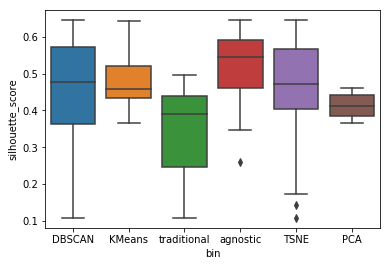

In [16]:
a = df[["clustering", "silhouette_score"]].rename(columns={"clustering":"bin"})
b = df[["features", "silhouette_score"]].rename(columns={"features":"bin"})
c = df[["projection", "silhouette_score"]].rename(columns={"projection":"bin"})

df_long = a.append(b).append(c)

sns.boxplot(x="bin", y="silhouette_score", data=df_long[df_long["silhouette_score"]>0.1]);

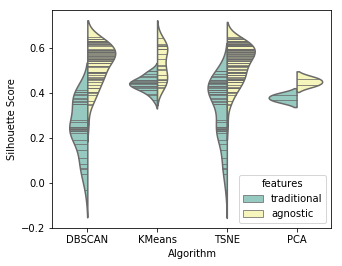

In [17]:
a = df[["clustering", "silhouette_score", "features"]].rename(columns={"clustering":"bin"})
b = df[["projection", "silhouette_score", "features"]].rename(columns={"projection":"bin"})

df_long_split = a.append(b)

fig = plt.figure(figsize=(5,4))

h = sns.violinplot(x="bin", y="silhouette_score", hue="features", data=df_long_split,
               split=True, inner="stick", palette="Set3");
h.set(xlabel='Algorithm', ylabel='Silhouette Score')

df_long_split.groupby(["bin","features"]).agg(['mean', 'std'])

fig.savefig("./paper_figs/violin_plot_silhouette_score.eps")

silhouette_score          
                               mean       std
features    bin                              
agnostic    DBSCAN         0.525027  0.087089
            KMeans         0.528174  0.072478
            PCA            0.448967  0.018696
            TSNE           0.527726  0.083198
traditional DBSCAN         0.247766  0.120978
            KMeans         0.439726  0.033071
            PCA            0.378089  0.017132
            TSNE           0.323967  0.136564

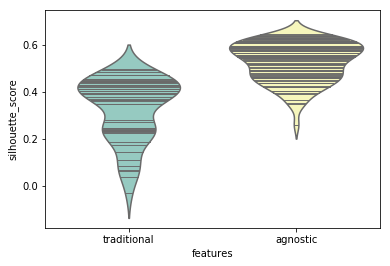

In [18]:
a = df[["clustering", "silhouette_score", "features"]].rename(columns={"clustering":"bin"})
b = df[["projection", "silhouette_score", "features"]].rename(columns={"projection":"bin"})

df_long_split_ss = a.append(b)


sns.violinplot(x="features", y="silhouette_score", data=df_long_split,
               split=True, inner="stick", palette="Set3");

df_long_split_ss.groupby(["features","bin"]).agg(['mean', 'std'])

## With VI

In [ ]:
a = df[["clustering", "vi_class", "vi_vocation", "vi_vehicletype", "features"]].rename(columns={"clustering":"bin"})
b = df[["projection", "vi_class", "vi_vocation", "vi_vehicletype", "features"]].rename(columns={"projection":"bin"})

df_long_split = a.append(b)


fig = plt.figure(figsize=(5,4))
h = sns.violinplot(x="bin", y="vi_vehicletype", hue="features", data=df_long_split,
               split=True, inner="stick", palette="Set3")
h.set(xlabel='Algorithm', ylabel='Variation of Information to Vehicle Type')
fig.savefig("./paper_figs/violin_plot_vi_type.eps")

fig = plt.figure(figsize=(5,4))
h = sns.violinplot(x="bin", y="vi_vocation", hue="features", data=df_long_split,
               split=True, inner="stick", palette="Set3")
h.set(xlabel='Algorithm', ylabel='Variation of Information to Vehicle Vocation')
fig.savefig("./paper_figs/violin_plot_vi_vocation.eps")

fig = plt.figure(figsize=(5,4))
h = sns.violinplot(x="bin", y="vi_class", hue="features", data=df_long_split,
               split=True, inner="stick", palette="Set3");
h.set(xlabel='Algorithm', ylabel='Variation of Information to Vehicle Class')
fig.savefig("./paper_figs/violin_plot_vi_class.eps")

df_long_split.groupby(["bin","features"]).agg(['mean', 'std']).round(2)

vi_class       vi_vocation       vi_vehicletype      
                       mean   std        mean   std           mean   std
bin    features                                                         
DBSCAN agnostic        2.82  0.33        4.14  0.16           3.37  0.27
       traditional     2.60  0.36        3.80  0.25           3.14  0.24
KMeans agnostic        3.09  0.19        4.19  0.18           3.58  0.15
       traditional     3.11  0.13        3.99  0.11           3.44  0.15
PCA    agnostic        2.92  0.12        4.19  0.22           3.45  0.10
       traditional     3.04  0.09        4.06  0.06           3.44  0.02
TSNE   agnostic        2.89  0.33        4.15  0.17           3.43  0.26
       traditional     2.80  0.39        3.87  0.23           3.25  0.26